In [3]:
# Install imgeio in order to generate an animated gif showing the image generating process
!pip install imageio

In [0]:
import tensorflow as tf
tf.enable_eager_execution()

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import time

from IPython import display

In [0]:
(image_train, label_train), (_, _) = tf.keras.datasets.mnist.load_data()

In [38]:
image_train.shape

(60000, 28, 28)

In [0]:
#keras needs another dimention for depth
image_train = image_train.reshape(image_train.shape[0],28,28,1).astype('float32')
image_train = (image_train-127)/127  #range -1 to 1

In [0]:
BUFFER_SIZE = image_train.shape[0]
BATCH_SIZE = 256

In [0]:
dataset = tf.data.Dataset.from_tensor_slices(image_train).shuffle(BATCH_SIZE).batch(BATCH_SIZE)

In [42]:
image_train[:5].shape

(5, 28, 28, 1)

therefore dataformat is channels last.

Format : (batch, rows, columns, channels)

### The Generator Model

The generator is responsible for creating convincing images that are good enough to fool the discriminator. The network architecture for the generator consists of Conv2DTranspose (Upsampling) layers. We start with a fully connected layer and upsample the image two times in order to reach the desired image size of 28x28x1. We increase the width and height, and reduce the depth as we move through the layers in the network. We use Leaky ReLU activation for each layer except for the last one where we use a tanh activation.

In [0]:

def make_generator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
      
    model.add(tf.keras.layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size
    
    model.add(tf.keras.layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)  
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)    
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)
  
    return model

In [0]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))
      
    model.add(tf.keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))
       
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1))
     
    return model

In [0]:
generator = make_generator_model()
discriminator = make_discriminator_model()

In [70]:
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 12544)             1254400   
_________________________________________________________________
batch_normalization_v1_3 (Ba (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 12544)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_v1_4 (Ba (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 7, 7, 128)         0         
__________

In [71]:
discriminator.summary()

ValueError: ignored

In [0]:
def generator_loss(generated_output):
    return tf.losses.sigmoid_cross_entropy(tf.ones_like(generated_output), generated_output)

In [0]:
def discriminator_loss(real_out, generated_out):
    real_loss = tf.losses.sigmoid_cross_entropy(multi_class_labels = tf.ones_like(real_out), logits = real_out)
    generated_loss = tf.losses.sigmoid_cross_entropy(multi_class_labels = tf.zeros_like(generated_out), logits = generated_out)
    
    total_loss =  real_loss + generated_loss 
    
    return total_loss

In [0]:
g_optimizer = tf.train.AdamOptimizer(1e-4)
d_optimizer = tf.train.AdamOptimizer(1e-4)

In [0]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

checkpoint = tf.train.Checkpoint(g_optimizer=g_optimizer,
                                 d_optimizer=d_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [0]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# We'll re-use this random vector used to seed the generator so
# it will be easier to see the improvement over time.
random_vector_for_generation = tf.random_normal([num_examples_to_generate,
                                                 noise_dim])

In [77]:
random_vector_for_generation.shape

TensorShape([Dimension(16), Dimension(100)])

In [78]:
random_vector_for_generation

<tf.Tensor: id=27133, shape=(16, 100), dtype=float32, numpy=
array([[ 3.1630533 ,  0.446552  ,  1.0309806 , ..., -1.5585662 ,
        -0.31002977,  0.28938094],
       [ 1.5177228 , -0.11072414,  0.21873368, ..., -1.1930861 ,
         0.83061993, -0.6922592 ],
       [ 0.7307199 ,  0.27259094, -0.02138241, ...,  0.273442  ,
         0.9807966 , -1.11082   ],
       ...,
       [-0.62099844,  0.5401312 ,  0.7850947 , ...,  0.10086378,
         0.4321285 , -1.3103186 ],
       [ 1.3605839 , -1.9107544 , -1.3342837 , ..., -0.21703106,
        -0.46796685,  0.61456645],
       [ 1.1650494 , -0.16848762,  1.8501627 , ..., -1.0660437 ,
        -0.8250854 , -2.07252   ]], dtype=float32)>

In [0]:
def train_step(images):
    noise = tf.random_normal([BATCH_SIZE, noise_dim])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as dis_tape:
        
        generated_images = generator(noise, training = True)
        real_out = discriminator(images, training =True)
        generated_out = discriminator(generated_images, training = True)

        gen_loss = generator_loss(generated_out)
        dis_loss = discriminator_loss(real_out, generated_out)

    
    gen_grad = gen_tape.gradient(gen_loss, generator.variables)
    dis_grad = dis_tape.gradient(dis_loss, discriminator.variables)
    
    #print(gen_grad)
    
    g_optimizer.apply_gradients(zip(gen_grad, generator.variables))
    d_optimizer.apply_gradients(zip(dis_grad, discriminator.variables))
        
        

In [82]:
for i, j in zip([1,2],[3,4]):
    print('i={},   j={}'.format(i,j))

i=1,   j=3
i=2,   j=4


In [0]:
train_step = tf.contrib.eager.defun(train_step)

In [0]:
def generate_and_save_images(model, epoch, test_input):
    # make sure the training parameter is set to False because we
    # don't want to train the batchnorm layer when doing inference.
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4,4))
  
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
        
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [0]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        
        for images in dataset:
            train_step(images)
        
        display.clear_output(wait = True)
        generate_and_save_images(generator,
                               epoch + 1,
                               random_vector_for_generation)
        # saving (checkpoint) the model every 15 epochs
        if (epoch + 1) % 15 == 0:
          checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Time taken for epoch {} is {} sec'.format(epoch + 1,
                                                      time.time()-start))
    # generating after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                           epochs,
                           random_vector_for_generation)

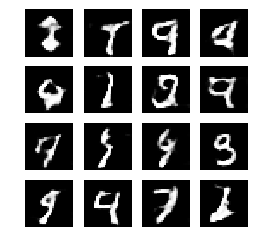

CPU times: user 3min 48s, sys: 1min 22s, total: 5min 10s
Wall time: 20min 35s


In [86]:
%%time
train(dataset, EPOCHS)

In [87]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [0]:
# Display a single image using the epoch number
def display_image(epoch_no):
    return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

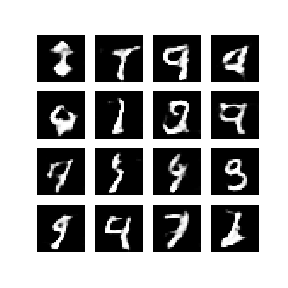

In [98]:
display_image(EPOCHS)

In [107]:
#Generate a GIF of all the saved images
with imageio.get_writer('dcgan.gif', mode='I') as writer:
    filenames = glob.glob('image*.png')
    filenames = sorted(filenames)
    last = -1
    for i,filename in enumerate(filenames):
        frame = 5*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

# this is a hack to display the gif inside the notebook
os.system('cp dcgan.gif dcgan.gif.png')

0

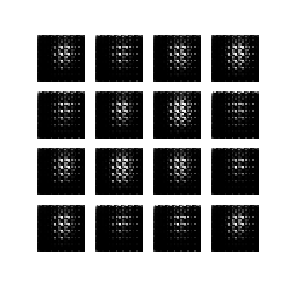

In [108]:
#Display the animated gif with all the mages generated during the training of GANs.
display.Image(filename="dcgan.gif.png")

In [0]:
#Download the animated gif

from google.colab import files
files.download('dcgan.gif')